In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, Embedding, SimpleRNN,Conv1D, MaxPooling1D
from tensorflow_recommenders .layers.loss import HardNegativeMining
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib as mpl
from tensorflow.config import list_physical_devices
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric, confusion_matrix
from tqdm.notebook import tqdm
from keras.utils import plot_model

print(list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [99]:
class Input_generator():
    def __init__(self, variable_range, number_of_circles, dimensions=2):
        """
        Initializes the Input_generator class.

        Args:
        - variable_range: a tuple (r_min, r_max) specifying the range of radii for the detectors
        - number_of_circles: the number of circular detectors to generate
        - dimensions: the number of dimensions for the generated data (default = 2)
        """
        self.r_min = variable_range[0]
        self.r_max = variable_range[1]
        self.n_circles = number_of_circles
        self.dimensions = dimensions
        self.radii = np.linspace(self.r_min, self.r_max, self.n_circles)
    
    def generate_2d_intersections(self, line_angles):
        """
        Generates 2D intersections based on given line angles.

        Args:
        - line_angles: an array of line angles

        Returns:
        - intersections: an array of 2D intersections
        """
        intersections_x = np.outer(np.cos(line_angles), self.radii)
        intersections_y = np.outer(np.sin(line_angles), self.radii)
        intersections = np.concatenate((np.dstack((intersections_x, intersections_y)), np.dstack((-1*intersections_x, -1*intersections_y))), axis=1)
        intersections = intersections.reshape(-1, intersections.shape[-1])
        return intersections
    
    def generate_3d_intersections(self, line_angles):
        """
        Generates 3D intersections based on given line angles.

        Args:
        - line_angles: an array of line angles

        Returns:
        - intersections: an array of 3D intersections
        """
        intersections_x = np.outer(np.cos(line_angles[:,0]) * np.sin(line_angles[:,1]), self.radii)
        intersections_y = np.outer(np.sin(line_angles[:,0]) * np.sin(line_angles[:,1]), self.radii)
        intersections_z = np.outer(np.cos(line_angles[:,1]), self.radii)
        intersections = np.concatenate((np.dstack((intersections_x, intersections_y, intersections_z)), np.dstack((-1*intersections_x, -1*intersections_y, -1*intersections_z))), axis=1)
        intersections = intersections.reshape(-1, intersections.shape[-1])
        return intersections
    
    def get(self, number_of_lines, shuffle=True):
        """
        Generates data with given number of lines.

        Args:
        - number_of_lines: the number of lines to generate
        - shuffle: a flag indicating whether to shuffle the generated data (default = True)

        Returns:
        - line_angles: an array of line angles
        - intersections: an array of intersections
        """
        assert self.dimensions == 2
        line_angles = np.random.rand(number_of_lines) * np.pi
        intersections = self.generate_2d_intersections(line_angles)

        noise = np.random.normal(0, 0.001, (intersections.shape[0], intersections.shape[1]))
        intersections = intersections * (1 + noise)
        
        if shuffle:
            s = np.random.choice(len(intersections), len(intersections), replace=False)
            intersections = intersections[s]
        return np.sort(line_angles), intersections
    
    def get_random(self, min_number_of_lines, max_number_of_lines, dropout_rate, shuffle=True):
        """
        Generates random data with a random number of lines.

        Args:
        - min_number_of_lines: the minimum number of lines to generate
        - max_number_of_lines: the maximum number of lines to generate
        - dropout_rate: the rate of dropout (probability of excluding an intersection)
        - shuffle: a flag indicating whether to shuffle the generated data (default = True)

        Returns:
        - line_angles: an array of line angles
        - intersections: an array of intersections
        """
        assert self.dimensions == 2
        number_of_lines = np.random.randint(min_number_of_lines, max_number_of_lines)
        line_angles = np.random.rand(number_of_lines) * np.pi
        intersections = self.generate_2d_intersections(line_angles)
        intersections = intersections[np.argwhere([np.random.rand() > dropout_rate for i in intersections])[:,0]]
        
        noise = np.random.normal(0, 0.001, (intersections.shape[0], intersections.shape[1]))
        intersections = intersections * (1 + noise)
        
        if shuffle:
            s = np.random.choice(len(intersections), len(intersections), replace=False)
            intersections = intersections[s]
            
        return np.sort(line_angles), intersections
    
    def get_random_fixed_angles(self, min_number_of_lines, max_number_of_lines, dropout_rate, shuffle = True):
        """
        Generates fixed angle data with a random number of lines.

        Args:
        - min_number_of_lines: the minimum number of lines to generate
        - max_number_of_lines: the maximum number of lines to generate
        - dropout_rate: the rate of dropout (probability of excluding an intersection)
        - shuffle: a flag indicating whether to shuffle the generated data (default = True)

        Returns:
        - line_angles: an array of line angles
        - intersections: an array of intersections
        """
        assert self.dimensions == 2
        number_of_lines = np.random.randint(min_number_of_lines, max_number_of_lines)
        line_angles = np.arange(3, number_of_lines+3) * np.pi / (number_of_lines+3)
        intersections = self.generate_2d_intersections(line_angles)
        intersections = intersections[np.argwhere([np.random.rand() > dropout_rate for i in intersections])[:,0]]
        
        noise = np.random.normal(0, 0.001, (intersections.shape[0], intersections.shape[1]))
        intersections = intersections * (1 + noise)
        
        if shuffle:
            s = np.random.choice(len(intersections), len(intersections), replace=False)
            intersections = intersections[s]
            
        return np.sort(line_angles), intersections
    
        
    def get_seperate_data(self, input_data):
        """
        Separates input data into positive and negative samples.

        Args:
        - input_data: the input data to separate

        Returns:
        - pos_samples: an array of positive samples
        - neg_samples: an array of negative samples
        """
        pos_samples = input_data[np.random.randint(0, len(input_data), len(input_data)//2), 0:2]
        ids = np.random.randint(0, len(input_data), len(input_data)//2)
        ids2 = ids + 1
        ids2[ids2 >= len(input_data)] = 0
        neg_samples = np.concatenate((input_data[ids, 0:1], input_data[ids2, 0:1]), axis=1)
        return pos_samples, neg_samples

    def get_3d(self, number_of_lines, shuffle=True):
        """
        Generates data with given number of lines.

        Args:
        - number_of_lines: the number of lines to generate
        - shuffle: a flag indicating whether to shuffle the generated data (default = True)

        Returns:
        - line_angles: an array of line angles
        - intersections: an array of intersections
        """
        assert self.dimensions == 3
        line_angles = np.random.rand(number_of_lines, 2) * np.pi
        intersections = self.generate_3d_intersections(line_angles)

        noise = np.random.normal(0, 0.001, (intersections.shape[0], intersections.shape[1]))
        intersections = intersections * (1 + noise)
        
        if shuffle:
            s = np.random.choice(len(intersections), len(intersections), replace=False)
            intersections = intersections[s]
        return np.sort(line_angles), intersections
        
    
    def get_random_3d(self, min_number_of_lines, max_number_of_lines, dropout_rate, shuffle=True):
        """
        Generates random data with a random number of lines.

        Args:
        - min_number_of_lines: the minimum number of lines to generate
        - max_number_of_lines: the maximum number of lines to generate
        - dropout_rate: the rate of dropout (probability of excluding an intersection)
        - shuffle: a flag indicating whether to shuffle the generated data (default = True)

        Returns:
        - line_angles: an array of line angles
        - intersections: an array of intersections
        """
        assert self.dimensions == 3
        number_of_lines = np.random.randint(min_number_of_lines, max_number_of_lines)
        line_angles = np.random.rand(number_of_lines, 2) * np.pi
        intersections = self.generate_3d_intersections(line_angles)
        intersections = intersections[np.argwhere([np.random.rand() > dropout_rate for i in intersections])[:,0]]
        
        noise = np.random.normal(0, 0.001, (intersections.shape[0], intersections.shape[1]))
        intersections = intersections * (1 + noise)
        
        if shuffle:
            s = np.random.choice(len(intersections), len(intersections), replace=False)
            intersections = intersections[s]
            
        return np.sort(line_angles), intersections
    

In [52]:
class Dataset():
    def __init__(self, data_features, data_targets):
        """
        Initializes the Dataset class.

        Args:
        - data_features: the input features
        - data_targets: the target values
        """
        self.features = data_features
        self.targets = data_targets
        self.x_dim = self.features.shape
        self.y_dim = self.targets.shape
    
    def feature_hist(self, multivariate=False, normalized=False):
        """
        Plots histograms of the input features.

        Args:
        - multivariate: a flag indicating whether to plot a 2D histogram (default = False)
        - normalized: a flag indicating whether to use normalized features (default = False)
        """
        if normalized:
            features = self.norm_features
        else:
            features = self.features
        
        if not multivariate:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            p = ax[0].hist(features[:, :, 0].flatten(), bins=100)
            q = ax[1].hist(features[:, :, 1].flatten(), bins=100)
            ax[0].set_title("x values")
            ax[1].set_title("y values")
            ax[0].set_xlabel("x")
            ax[1].set_xlabel('y')
            ax[0].set_ylabel("Count")
            ax[1].set_ylabel("Count")
        else:
            hist, x_edges, y_edges = np.histogram2d(features[:, :, 0].flatten(), features[:, :, 1].flatten(), bins=100)
            plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='hot')
            plt.xlabel('x')
            plt.ylabel('y')
    
    def target_hist(self, normalized=False):
        """
        Plots a histogram of the target values.

        Args:
        - normalized: a flag indicating whether to use normalized targets (default = False)
        """
        if normalized:
            targets = self.norm_targets
        else:
            targets = self.targets
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        p = ax.hist(targets.flatten(), bins=100)
        ax.set_title("Histogram of line parameters")
        ax.set_xlabel('Angle')
        ax.set_ylabel('Count')
    
    def normalize(self, f_mean, f_std, t_mean, t_std):
        """
        Normalizes the features and targets.

        Args:
        - f_mean: mean of the features
        - f_std: standard deviation of the features
        - t_mean: mean of the targets
        - t_std: standard deviation of the targets
        """
        self.norm_features = (self.features - f_mean) / f_std
        self.norm_targets = (self.targets - t_mean) / t_std


In [131]:
  
def plot_results(coord_groups, angles):
    """
    Plots the results of coordinate groups and predicted angles.

    Args:
    - coord_groups: a list of coordinate groups
    - angles: a list of predicted angles
    """
    plt.figure(figsize=(5, 5))
    s = np.linspace(0, 2*np.pi, 100)
    for r in gen.radii:
        plt.plot(np.cos(s)*r, np.sin(s)*r, c='b')
        
    c = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
          'lightblue', 'lime', 'teal', 'lavender', 'tan', 'salmon', 'gold', 'darkgreen', 'navy', 'maroon']

    for n, i in enumerate(angles):
        x = np.linspace(-r-1, r+1, 100)
        y = np.tan(i) * x
        plt.plot(x, y, c=c[n], label=f"{n}: {i:.2f}")
    
    for n, i in enumerate(coord_groups):
        i = np.array(i)
        plt.scatter(i[:, 0], i[:, 1], c=c[n])
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-r-1, r+1)
    plt.legend()
    plt.show()


In [100]:
gen = Input_generator((1, 6), 5)
train = [gen.get(3, True) for i in range(50000)]
t = np.array([i[0] for i in train])
f = np.array([i[1] for i in train])
data_reg = Dataset(f, t)

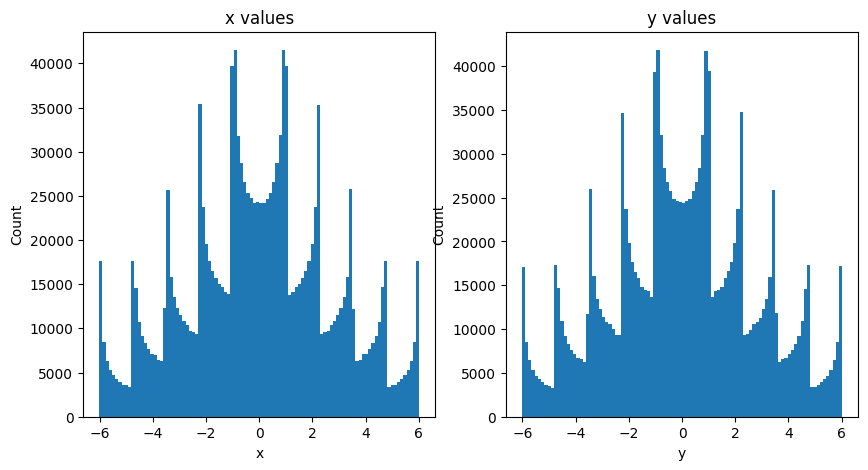

In [101]:
data_reg.feature_hist()

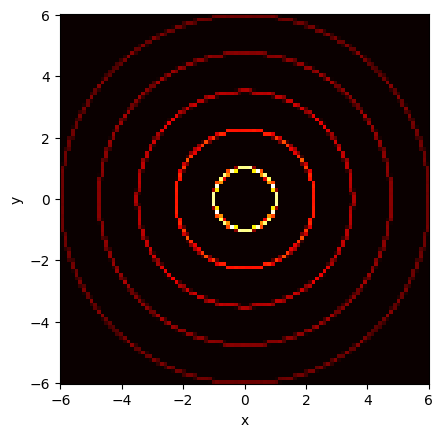

In [102]:
data_reg.feature_hist(True)

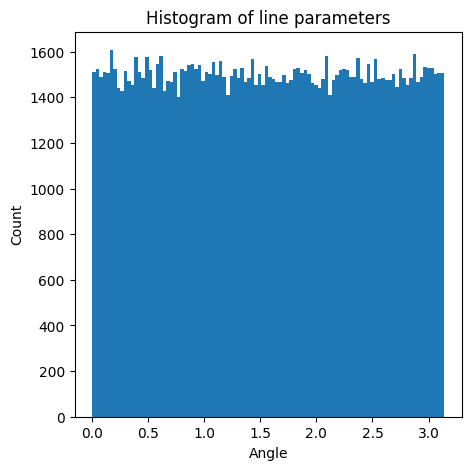

In [103]:
data_reg.target_hist()

In [104]:
f_mean = np.mean(data_reg.features)
f_std = np.std(data_reg.features)
t_mean = np.mean(data_reg.targets)
t_std = np.std(data_reg.targets)
data_reg.normalize(f_mean, f_std, t_mean, t_std)

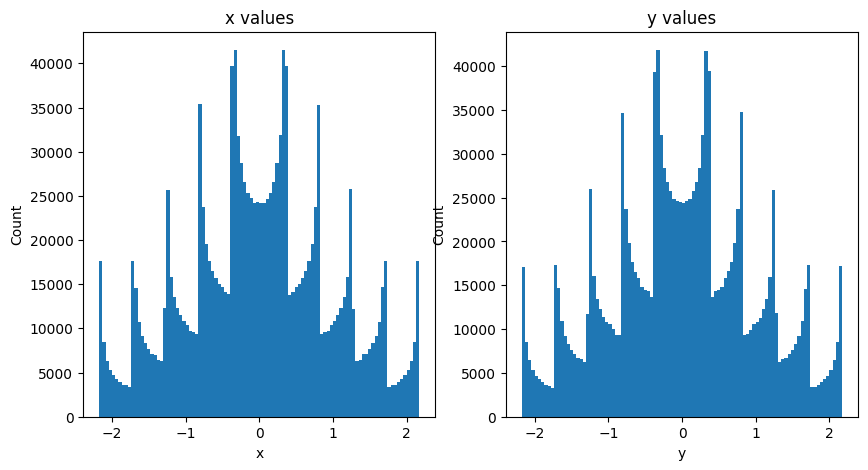

In [105]:
data_reg.feature_hist(False, True)

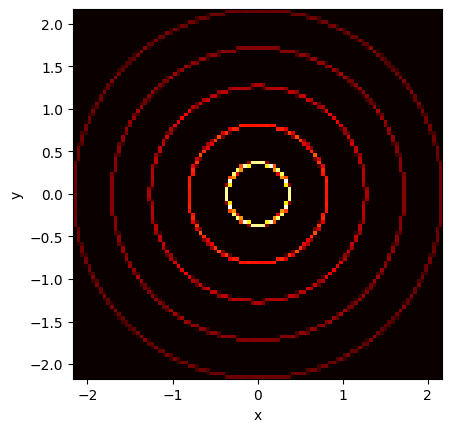

In [106]:
data_reg.feature_hist(True, True)

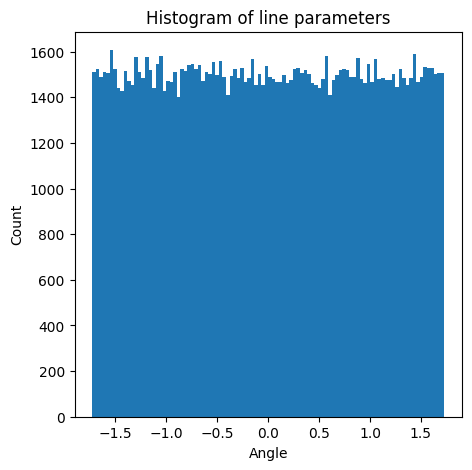

In [107]:
data_reg.target_hist(True)

In [108]:
class MCDropout(Dropout):
    def call(self,inputs):
        return super().call(inputs, training=True)


def regression_model(input_shape, output_shape):
    inputs = Input(shape = input_shape)
    inputs_flat = Flatten()(inputs)
    l0 = Dense(256, activation = 'relu')(inputs_flat)
    d0 = MCDropout(0.1)(l0)
    l1 = Dense(128, activation = 'relu')(d0)
    d1 = MCDropout(0.1)(l1)
    l2 = Dense(64, activation = 'relu')(d1)
    d2 = MCDropout(0.1)(l2)
    l3 = Dense(32, activation = 'relu')(d2)
    d3 = MCDropout(0.1)(l3)
    output = Dense(output_shape, activation = 'linear')(d3)
    
    model = Model(inputs, output)
    print(model.summary())
    return model 

In [109]:
regression_network = regression_model(data_reg.norm_features[0].shape, data_reg.norm_targets.shape[1])
optimizer = Adam(10**-4)
regression_network.compile(optimizer, loss = 'mse')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 2)]           0         
                                                                 
 flatten_3 (Flatten)         (None, 60)                0         
                                                                 
 dense_16 (Dense)            (None, 256)               15616     
                                                                 
 mc_dropout_11 (MCDropout)   (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 mc_dropout_12 (MCDropout)   (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256

In [110]:
train = False
if train:
    history = regression_network.fit(data_reg.norm_features, 
                    data_reg.norm_targets, 
                    #batch_size = 100, 
                    verbose = 0, 
                    epochs = 100, 
                    #steps_per_epoch = 1000,
                    validation_split = 0.1,
                    callbacks=[TqdmCallback(verbose=1), EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)])
    regression_network.save('./Regression.h5')
else:
    regression_network.load('./Regression.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

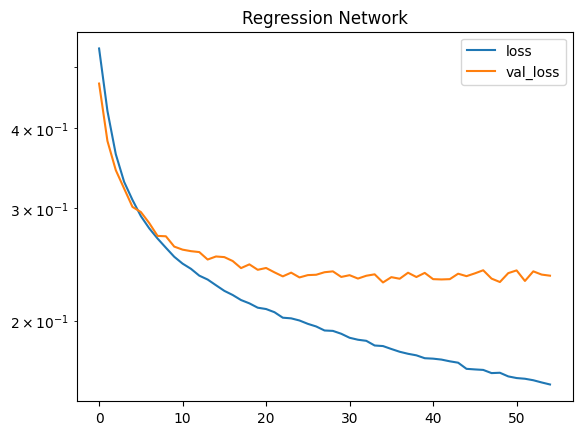

In [111]:
if train:
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.yscale('log')
    plt.legend()
    plt.title('Regression Network')

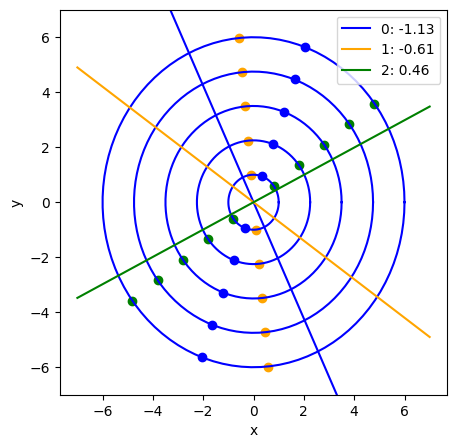

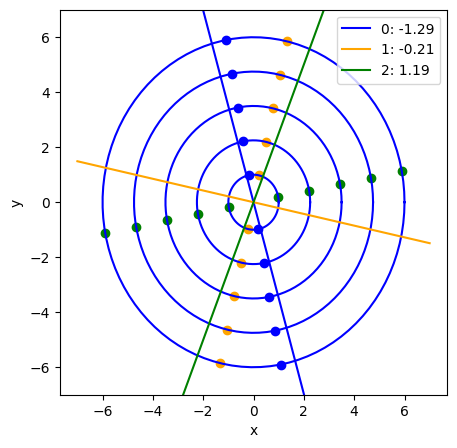

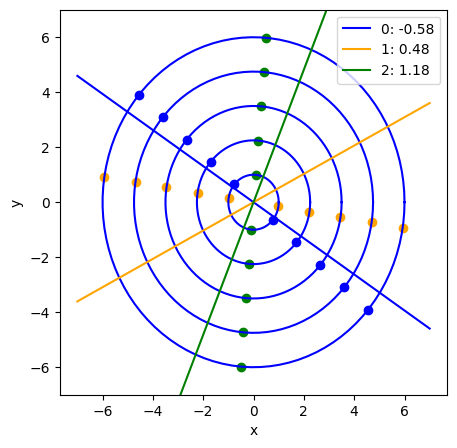

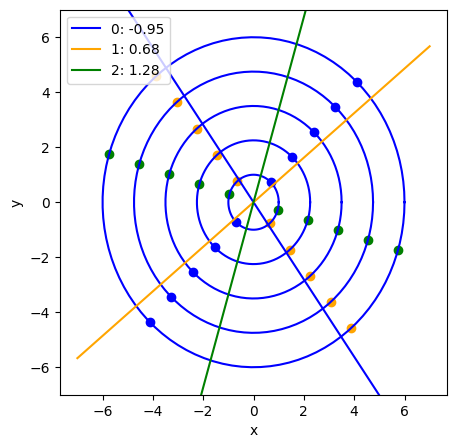

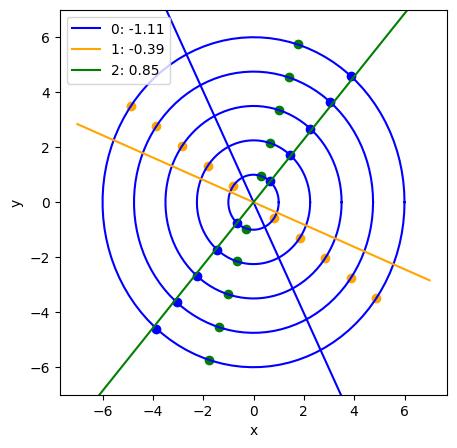

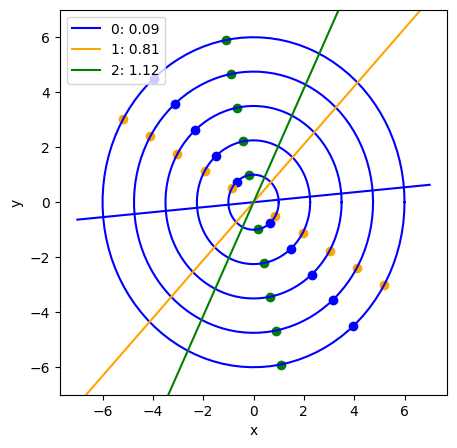

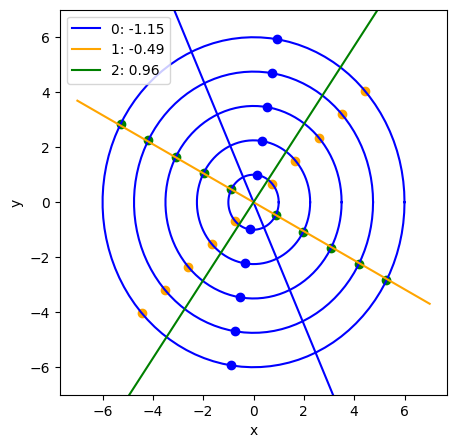

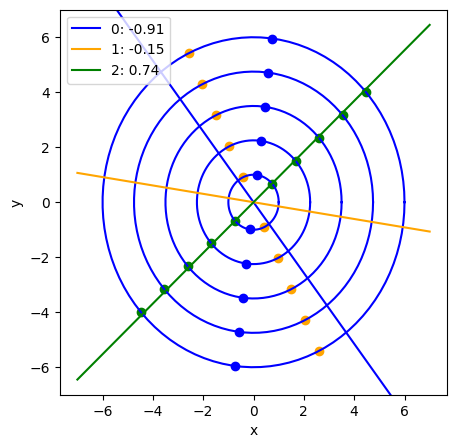

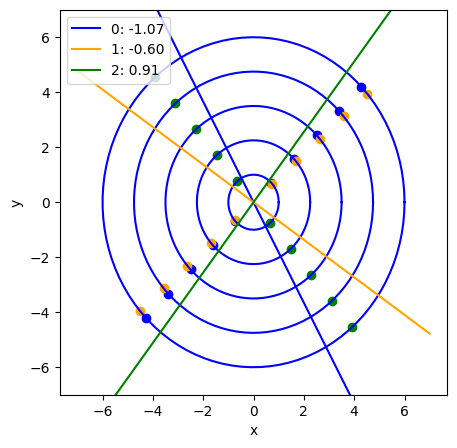

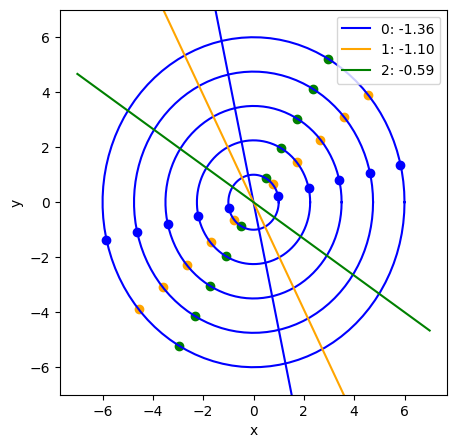

In [112]:
train = [gen.get(3, False) for i in range(10)]
t =np.array([i[0] for i in train])
f = np.array([i[1] for i in train])

results = regression_network.predict((f-f_mean)/f_std, verbose = 0)

f = f.reshape(10, 3, 10, 2)
for i in range(10):
    plot_results(f[i], results[i])

In [16]:
train = [gen.get(1, True) for i in range(50000)]
t = np.array([i[0] for i in train])
f = np.array([i[1] for i in train])

data_cnn = Dataset(f, t)
data_cnn.normalize(f_mean, f_std, t_mean, t_std)

In [133]:


def CNN_Model(dim = 2):
    
    CNN_model = Sequential()
    CNN_model.add(Conv1D(64, 2, strides = 2, activation='relu', input_shape=(None, dim)))

    CNN_model.add(Dense(10, activation = 'relu'))
    CNN_model.add(Dense(dim-1, activation = 'linear'))

    CNN_model.summary()
    optimizer = Adam(10**-4)
    CNN_model.compile(optimizer, loss = 'mse')
    return CNN_model

CNN_model = CNN_Model()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 64)          320       
                                                                 
 dense_27 (Dense)            (None, None, 10)          650       
                                                                 
 dense_28 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [134]:
train = False
if train:
    history = CNN_model.fit(data_cnn.norm_features, 
                        data_cnn.norm_targets, 
                        #batch_size = 100, 
                        verbose = 0, 
                        epochs = 1000, 
                        #steps_per_epoch = 1000,
                        validation_split = 0.1,
                        callbacks=[TqdmCallback(verbose=1), EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)])

else:
    CNN_model = load_model('./cnn_model.h5', compile=False)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

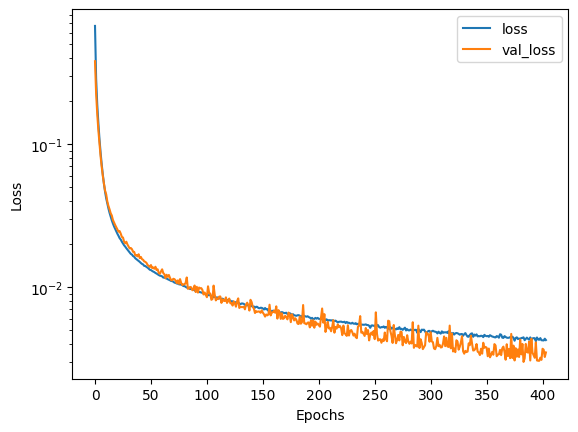

In [135]:
if train:
    CNN_model.save('./cnn_model.h5')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.legend()

In [20]:
pos, neg = gen.get_seperate_data(data_cnn.norm_features)

segment_labels = np.concatenate(([[[0,1]] * len(pos)], [[[1, 0]] * len(neg)]), axis = 1)
segment_data = np.concatenate((pos, neg))

shuffle_ids = np.arange(len(segment_labels[0]))
np.random.shuffle(shuffle_ids)

segment_labels = segment_labels[0][shuffle_ids]
segment_data = segment_data[shuffle_ids]

data_segment = Dataset(segment_data, segment_labels)
#data_segment.normalize(f_mean, f_std, 0, 1)

In [21]:
def get_segment_model(dim = 2):
    model = Sequential()
    model.add(Conv1D(32, 2, strides = 2, activation='relu', input_shape=(2, dim)))
    model.add(MaxPooling1D(1))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(64, activation = 'relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(32, activation = 'relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(2, activation = 'softmax'))

    model.summary()
    optimizer = Adam(10**-4)
    model.compile(optimizer, loss = 'bce')
    return model

segment_model = get_segment_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 32)             160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               4224      
                                                                 
 mc_dropout_4 (MCDropout)    (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                      

In [22]:
train = False
if train:
    history = segment_model.fit(data_segment.features, 
                        data_segment.targets, 
                        #batch_size = 100, 
                        verbose = 0, 
                        epochs = 1000, 
                        #steps_per_epoch = 1000,
                        validation_split = 0.1,
                        callbacks=[TqdmCallback(verbose=1), EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)])
else:
    segment_model = load_model('./segment_model.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

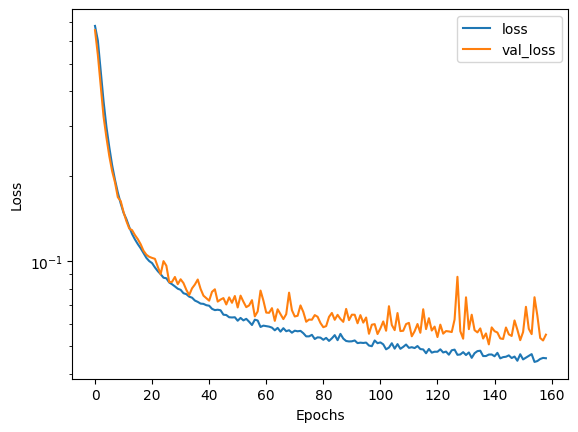

In [23]:
if train:
    segment_model.save('./segment_model.h5')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.legend()

In [168]:
class Predictor():
    def __init__(self, classifier, angle_finder):
        """
        Initializes the Predictor class.

        Args:
        - classifier: the classifier model for grouping coordinates
        - angle_finder: the angle finder model for predicting angles
        """
        self.classifier = classifier
        self.angle_finder = angle_finder
    
    def get_groups(self, input_data, cutoff):
        """
        Groups input data coordinates based on the classifier's predictions.

        Args:
        - input_data: the input coordinates to group
        - cutoff: the cutoff value for determining group membership

        Returns:
        - groups: a list of groups, each containing a list of coordinates
        """
        groups = [[list(input_data[0])]]
        for coordinate in (input_data[1:]):
            grouped = False
            
            inputs = np.repeat([coordinate], len(groups), axis=0)
            inputs = (np.dstack((inputs, [j[0] for j in groups]))-f_mean) / f_std
            outputs = self.classifier.predict(inputs, verbose=0)
            argmax_output = np.argmax(outputs[:, 1])
            if outputs[argmax_output][1] > cutoff:
                grouped = True
                groups[argmax_output].append(list(coordinate))
            if not grouped:
                groups.append([list(coordinate)])
        return groups
    
    def predict(self, input_data, cutoff):
        """
        Predicts angles for input data.

        Args:
        - input_data: the input data containing sets of coordinates of shape (experiments, hits, coordinates)
        - cutoff: the cutoff value for determining group membership

        Returns:
        - output_data: a list of predicted groups, angles and the errors of those angles. 
        """
        output_data = []
        for set_of_coords in tqdm(input_data):
            groups = self.get_groups(set_of_coords, cutoff)
            all_angles = []
            all_std = []
            for line in groups:
                angles = self.angle_finder.predict((np.array([line])-f_mean)/f_std, verbose=0)
                angles = angles * t_std + t_mean
                avg_angle = np.average(angles)
                all_angles.append(avg_angle)
                all_std.append(np.std(angles))
            output_data.append([groups, all_angles, all_std])
        return output_data


In [169]:
predictor = Predictor(segment_model, CNN_model)

In [170]:
random_tracks = [gen.get_random_fixed_angles(5, 12, 0.01) for i in range(10)]
random_targets = [np.array(d[0]) for d in random_tracks]
random_features = [np.array(d[1]) for d in random_tracks]


In [171]:
a = predictor.predict(random_features, 0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

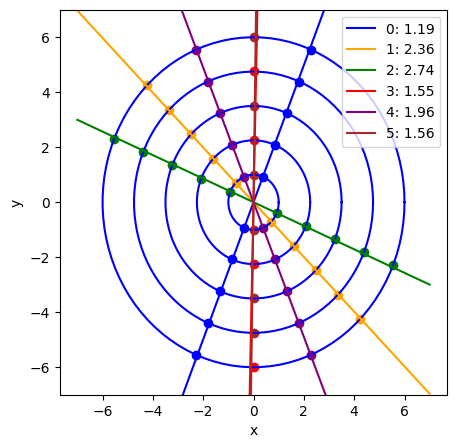

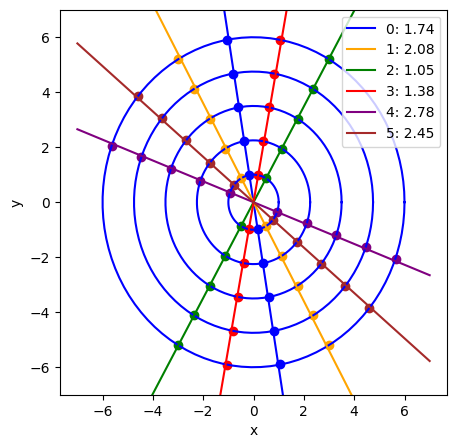

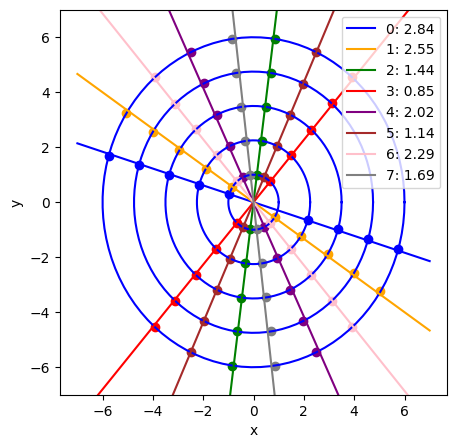

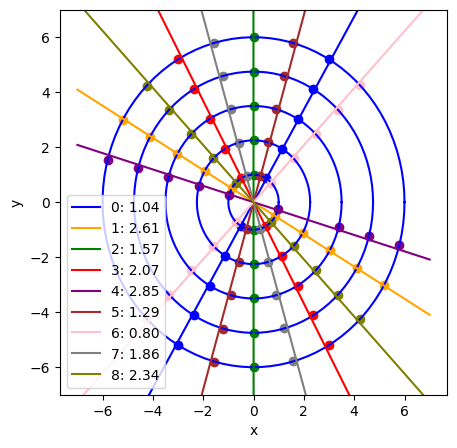

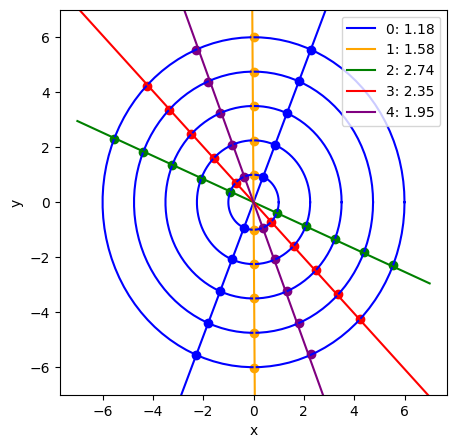

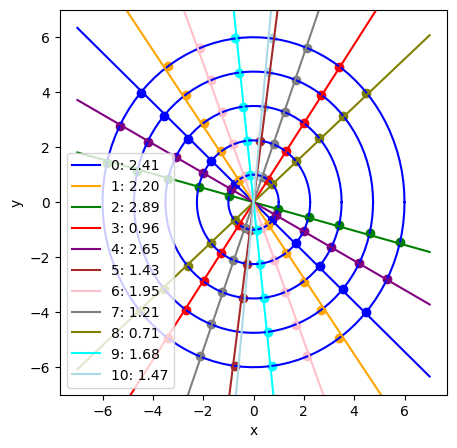

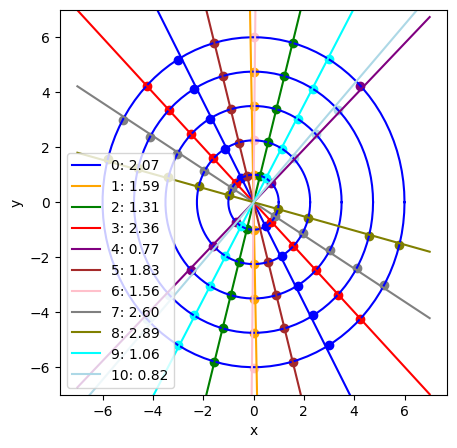

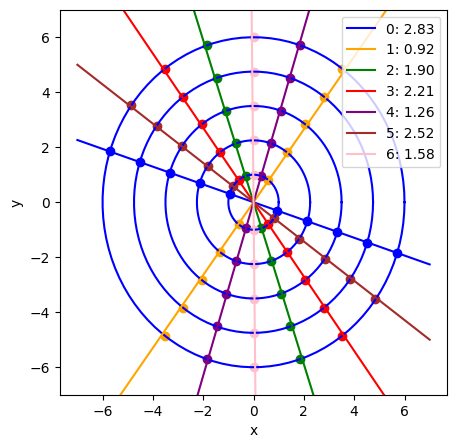

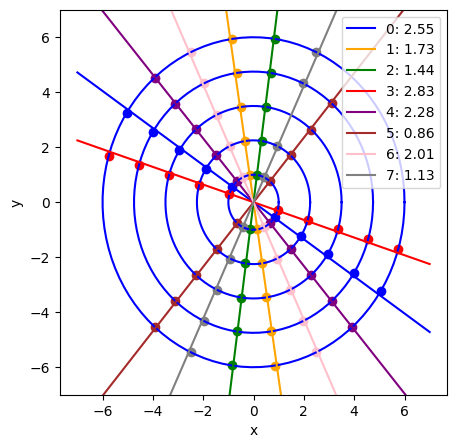

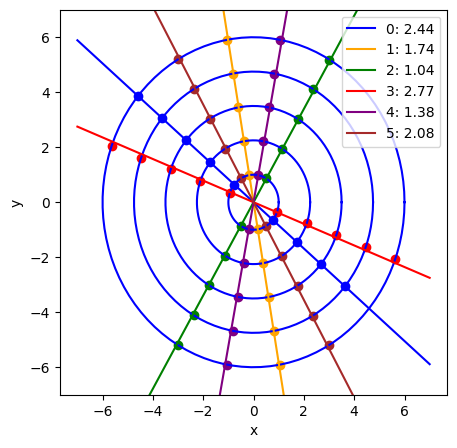

In [173]:
for i in range(10):
    plot_results(a[i][0], a[i][1])

